In [1]:
!pip install dill

from dill.source import getsource

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.3 MB/s eta 0:00:00


# 1. Perceptron

In this first problem, you will implement the perceptron algorithm. Since the algorithm requires linearly separate data and real data is usually noisy, we will have to use a synthetic example.

Model
- $X \in \mathbb{R}^{m \times n}$ : Dataset   
- $w \in \mathbb{R}^{n}$ : parameters   
- $\hat{y} = \text{sign}(Xw)$

In [2]:
import torch

# Data generation for perceptron problem
torch.manual_seed(42)

m, d = 30, 2
X_perceptron = torch.randn(m, d)  # Gernerate random data
w_opt = torch.randn(d) # Generate random optimal solution
y_perceptron = torch.sign(X_perceptron.matmul(w_opt)) # y = sign()

We've given you a template for the perceptron algorithm. Calculate the following remaining functions:

1. (3pts) Calculate the theoretical margin given the optimal linear classifier
2. (3pts) Compute the condition for when the perceptron algorithm makes an update on a specific example
3. (3pts) Compute the perceptron algorithm update to the weights when the update condition is satisfied

You do not need to change `perceptron_algorithm`.

In [3]:
def perceptron_margin(X, w_opt):
    # X := Tensor(float) of size (m,d) --- This is a batch of m examples of
    #     of dimension d
    #
    # w_opt := Tensor(float) of size (d,) --- This is the ground truth linear
    #     weights
    #
    # Return := Tensor(float) of size (1,) --- This is the theoretical margin
    #
    # Fill in the rest
    return torch.min(torch.norm(X @ w_opt) / torch.norm(w_opt))

def perceptron_update_condition(xi, yi, w):
    # xi := Tensor(float) of size (d,) --- This is a a single example of
    #     of dimension d
    #
    # yi := Tensor(float) of size (1,) --- This is a single label for the
    #     example xi
    #
    # w := Tensor(float) of size (d,) --- This is the current estimate of the
    #     linear weights
    #
    # Return := Tensor(bool) of size (1,) --- This is true if the perceptron
    #     algorithim will do an update on this example, and false otherwise
    #
    # Fill in the rest
    return torch.sign(yi) != torch.sign(xi @ w)

def perceptron_update_weight(xi, yi, w):
    # xi := Tensor(float) of size (d,) --- This is a a single example of
    #     of dimension d
    #
    # yi := Tensor(float) of size (1,) --- This is a single label for the
    #     example xi
    #
    # w := Tensor(float) of size (d,) --- This is the current estimate of the
    #     linear weights
    #
    # Return := Tensor(float) of size (d,) --- This is the updated linear
    #     weights after performing the perceptron update
    #
    # Fill in the rest
    return w + (yi * xi)


def perceptron_algorithm(X, y, niters=100):
    m, d = X.size()
    w = torch.zeros(d)  # Initialize parameters into 0.

    for t in range(niters):
      # for i in range(m):
      #   xi, yi = X[i, :], y[i]
      for xi, yi in zip(X, y):
        if perceptron_update_condition(xi, yi, w):
          w = perceptron_update_weight(xi, yi, w)
          continue
      break

    return w, t

## Testing
### 1) Accuracy

`acc_perceptron` : Accuracy calculated by taking the mean of $\begin{cases}1 & \text{if } w^\top x_i = y_i \\ 0 & \text{otherwise} \end{cases}$

In [4]:
# Testing with the synthetic data
w_perceptron, t = perceptron_algorithm(X_perceptron, y_perceptron)
acc_perceptron = (torch.sign(X_perceptron @ w_perceptron) == torch.sign(y_perceptron)).float().mean() # Accuracy

print(f"Accuracy: {acc_perceptron:.2f} in {t} rounds.")

Accuracy: 0.90 in 0 rounds.


### 2) Convergence Theorem of the Perceptron Algorithm
The [Perceptron algorithm](https://github.com/JoonHyeok-hozy-Kim/upenn_mcit/blob/main/2408_Fall_2024/CIS_520/notes/03.md#theorem-3-convergence-theorem) stops after at most $\frac{1}{\gamma^2}$ rounds, and returns a hyperplane $w$ s.t. $\text{sign}(w^\top x_i) = y_i, \forall i\in[m]$
- i.e.) all points are correctly classified.

In [5]:
margin = perceptron_margin(X_perceptron,w_opt)
print(f"Margin: {margin:.2f}. The perceptron algorithm is guaranteed to terminate in {1/(margin**2):.2f} rounds.")

Margin: 5.48. The perceptron algorithm is guaranteed to terminate in 0.03 rounds.


### 3) Plotting the classifier


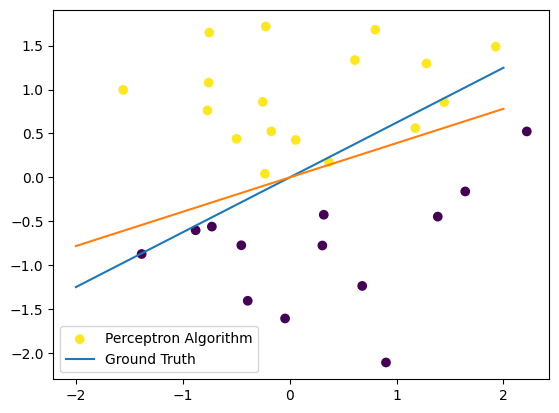

In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X_perceptron[:,0], X_perceptron[:,1], c=y_perceptron) # args : x=feature1, y=feature2, color_based on the label of y
X_range = torch.linspace(-2,2, 50)
plt.plot(X_range, -w_perceptron[0]/w_perceptron[1]*X_range) # estimated
plt.plot(X_range, -w_opt[0]/w_opt[1]*X_range) # optimal
plt.legend(['Perceptron Algorithm', 'Ground Truth'])


# 2. k-Nearest Neighbors

# Dataset: MNIST

One of the earliest **big** successes of machine learning was in recognizing handwritten digits. This proved incredibly useful, for example, when automatically parsing zip codes from handwritten envelopes. Today, we'll load the MNIST database of handwritten digits and use it to solve a binary classification problem: predicting whether an image of a handwritten digit is of a $0$ or of an $8$.

In [35]:
import torchvision

# Load MNIST dataset
mnist_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

train_x = mnist_train.data
train_y = mnist_train.targets

# MNIST contains digits of all different labels -- let's get just the 0 and 8 images.
train_x = train_x[torch.logical_or(train_y == 0, train_y == 8)]   # torch.logical_or
train_y = train_y[torch.logical_or(train_y == 0, train_y == 8)]


# Load the MNIST test dataset
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_x = mnist_test.data
test_y = mnist_test.targets

# MNIST contains digits of all different labels -- let's get just the 0 and 8 images.
test_x = test_x[torch.logical_or(test_y == 0, test_y == 8)]
test_y = test_y[torch.logical_or(test_y == 0, test_y == 8)]

When we investigate the data a little bit, we find that we have a training set of 11774 images, each image is 28 x 28 and is greyscale. Let's print out the shape of `train_x`, and also plot some images using matplotlib

torch.Size([11774, 28, 28])


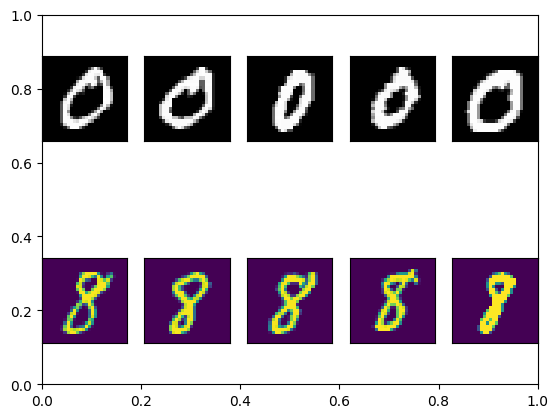

In [36]:
from matplotlib import pyplot as plt

print(train_x.shape)      # Size of the data!
fig, ax = plt.subplots()

# Plot 5 0's
for i in range(5):
  plt.subplot(2, 5, i+1)  # Plot the following image at the (i+1)-th location of the 2 by 5 subplot!
  plt.imshow(train_x[train_y == 0][i], cmap='gray') # Filter images from train_x s.t. train_y==0, and shwo the i-th image in grayscale.
  plt.tick_params(left=False, right=False, labelleft=False, bottom=False, labelbottom=False) # No ticks(눈금)

# Plot 5 8's.
for i in range(5, 10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_x[train_y == 8][i])
    plt.tick_params(left=False, right=False, labelleft=False, bottom=False, labelbottom=False)

Now, let's implement k Nearest Neighbors using simple Euclidean distance as our distance metric. We've given you a template for the actual algorithm, but you'll have to implement the guts of the algorithm yourself! Unfortunately, since
being able to program in PyTorch while effectively using broadcasting and other matrix operations is really important if you want to do machine learning, you'll need to implement the distance computation yourself without using `torch.cdist` or other similar
functions.

`test_x` $=\begin{bmatrix} a_{11} & \cdots & a_{1d} \\ \vdots & \ddots & \vdots \\ a_{m1} & \cdots & a_{md} \end{bmatrix} \in\mathbb{R}^{m\times d}$, `train_x` $=\begin{bmatrix} b_{11} & \cdots & b_{1d} \\ \vdots & \ddots & \vdots \\ b_{n1} & \cdots & b_{nd} \end{bmatrix} \in\mathbb{R}^{n\times d}$

We want to get `dist_mat` s.t. `dist_mat`$\displaystyle {}_{ij}=\sum_{t=1}^d (a_{it}-b_{jt})^2 = \sum_{t=1}^d (a_{it}^2 - 2a_{it}b_{jt}+b_{jt}^2) = \sum_{t=1}^d (a_{it}^2) -2\sum_{t=1}^d (a_{it}b_{jt}) + \sum_{t=1}^d (b_{jt}^2)`$

Then consider that   
`test_x`${}^2 = \begin{bmatrix} a_{ij}^2 \end{bmatrix} \in\mathbb{R}^{m\times d}$   
`train_x`${}^2 = \begin{bmatrix} b_{ij}^2 \end{bmatrix} \in\mathbb{R}^{n\times d}$      
`test_x` $\cdot$ `train_x`${}^\top = \begin{bmatrix} \displaystyle\sum_{t=1}^d (a_{it}b_{jt}) \end{bmatrix} \in\mathbb{R}^{m\times n}$   

In [47]:
def knn_distance_matrix(test_x, train_x):
    """
    Given a set of testing and training data, compute a matrix of distances between all test points and all training points.

    Args:
        test_x (m x d tensor): Testing data that we want to make predictions for.
        train_x (n x d tensor): Training data that we'll use for making classifications.

    Returns:
        dist_mat (m x n tensor): a matrix D so that D_ij is the distance between the ith test point and the jth training point.

    Hints:
        - You may find it helpful to know that the **squared** Euclidean distance between two vectors x and z, ||x - z||^2, can be computed as (x - z)'(x - z) = x'x - 2*x'z + z'z.
          This formulation is much easier to implement using simple matrix multiplication, elementwise products, and broadcasting.
        - Implementing this function without for loops will be the trickiest part of implementing the algorithm.
    """
    m, n = test_x.size(0), train_x.size(0)

    test_x_sq_rowsum = torch.sum(test_x ** 2, dim=1).unsqueeze(1)    # m x 1
    train_x_sq_rowsum = torch.sum(train_x ** 2, dim=1).unsqueeze(1)  # n x 1

    test_x_sq_mat = test_x_sq_rowsum.repeat(1, n)         # m x n
    train_x_sq_mat = train_x_sq_rowsum.repeat(1, m).T     # m x n
    test_x_train_x = test_x @ train_x.T

    return test_x_sq_mat - 2 * test_x_train_x + train_x_sq_mat


def knn_find_k_nearest_neighbors(D, k):
    """
    Given a distance matrix between test and train points, find the k nearest neighbors from the training points for each test point.

    Args:
        D (m x n tensor): a matrix D so that D_ij is the distance between the ith test point and jth training point (e.g., each *row* corresponds to a test point).
        k (int): How many nearest neighbors to find

    Returns:
        knn_inds (m x k tensor): For each test point, the indices of the k nearest neighbors in the training data. In other words, if knn_inds[i, j] = q, then (train_x[q], train_y[q]) is one of the k nearest neighbors to test_x[q].

    Hints:
        - This time, you can get some help from real functions in PyTorch. In particular, you may find the torch.topk function useful (https://pytorch.org/docs/stable/generated/torch.topk.html).
        - This function can be implemented in as little as 1 (relatively short) line of code. If you find yourself struggling, you're probably not using torch.topk as well as you should.
    """
    return torch.topk(D, k=k, dim=1, largest=False).indices   # Minimum distance -> largest=False


def knn_predict(train_y, knn_inds):
    """
    Given an m x k set of indices of nearest neighbors for each test point, use the training labels and these indices to make a final prediction for each test point.

    Args:
        train_y (n vector): Labels of the training data points
        knn_inds (m x k tensor): For each test point, the indices of the k nearest neighbors in the training data. In other words, if knn_inds[i, j] = q, then (train_x[q], train_y[q]) is one of the k nearest neighbors to test_x[q].

    Returns:
        predictions (m vector): A prediction of the label for each test point.

    Hints:
        - Suppose x is a vector with at least 6 entries and ix is a 2x3 matrix with entries [[0,2,4],[1,3,5]], then x[ix] will return a 2x3 matrix with entries [[x[0], x[2], x[4]],[x[1],x[3],x[5]]].
        - torch.mode (https://pytorch.org/docs/stable/generated/torch.mode.html) will be a pretty helpful function here.
    """
    topk_labels = train_y[knn_inds]
    return torch.mode(topk_labels, dim=1).values



def knn_algorithm(test_x, train_x, train_y, k=3):
    """
    Put it all together!

    Args:
        test_x (m x d tensor): Test points to make predictions for
        train_x (n x d tensor): Training data to use for making predictions.
        train_y (n, tensor): Training labels to use for making predictions.
        k (int): k to use in k nearest neighbors

    Returns:
        predictions (m, tensor): Predicted label for each test point.
    """
    # First, flatten the 28x28 images into 784 dimensional vectors. We'll also divide by 255 so that the feature values
    # are in [0,1] instead of [0, 255]. This is important because otherwise the distances will be so large that we'll have
    # floating point error problems!

    train_x_flat = train_x.view(train_x.size(-3), -1).float() / 255.
    test_x_flat = test_x.view(test_x.size(-3), -1).float() / 255.

    print('[Size Comparison] train_x : {} / train_x_flat : {}'.format(train_x.size(), train_x_flat.size()))

    D = knn_distance_matrix(test_x_flat, train_x_flat)
    knn_inds = knn_find_k_nearest_neighbors(D, k)
    return knn_predict(train_y, knn_inds)

Make predictions!

In [48]:
predictions = knn_algorithm(test_x, train_x, train_y, k=3)
print(f"You achieved a test accuracy of: {100 * (predictions == test_y).float().mean():.2f}%")

[Size Comparison] train_x : torch.Size([11774, 28, 28]) / train_x_flat : torch.Size([11774, 784])
You achieved a test accuracy of: 99.44%


The labels of the mistaken images are:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0]
And here are the images...


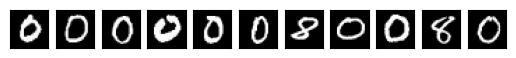

In [49]:
from matplotlib import pyplot as plt

mistake_indices = torch.where(~(predictions == test_y))[0]
print("The labels of the mistaken images are: ", test_y[mistake_indices].tolist())
print("And here are the images...")
for ix, mistake_ind in enumerate(mistake_indices):
    plt.subplot(1, len(mistake_indices), ix + 1)
    plt.imshow(test_x[ix], cmap='gray')
    plt.tick_params(left=False, right=False, labelleft=False, bottom=False, labelbottom=False)